In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')



In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rohanrao/air-quality-data-in-india")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/air-quality-data-in-india


In [3]:
# Load dataset
# Note: Download from https://www.kaggle.com/rohanrao/air-quality-data-in-india
df = pd.read_csv('/content/new_dataset1.csv')

# Display basic information
print("Dataset Info:")
print(df.info())
print("\nSummary Statistics:")
print(df.describe())



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46981 entries, 0 to 46980
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   City        46981 non-null  object 
 1   PM2.5       46981 non-null  float64
 2   PM10        46981 non-null  float64
 3   NO          46981 non-null  float64
 4   NO2         46981 non-null  float64
 5   NOx         46981 non-null  float64
 6   NH3         46981 non-null  float64
 7   CO          46981 non-null  float64
 8   SO2         46981 non-null  float64
 9   O3          46981 non-null  float64
 10  AQI         46981 non-null  float64
 11  AQI_Bucket  46981 non-null  object 
 12  Date        46981 non-null  object 
dtypes: float64(10), object(3)
memory usage: 4.7+ MB
None

Summary Statistics:
              PM2.5          PM10            NO           NO2           NOx  \
count  46981.000000  46981.000000  46981.000000  46981.000000  46981.000000   
mean      78.703210    16

In [4]:
# Check missing values
print("\nMissing Values:")
missing = df.isnull().sum()
print(missing)


Missing Values:
City          0
PM2.5         0
PM10          0
NO            0
NO2           0
NOx           0
NH3           0
CO            0
SO2           0
O3            0
AQI           0
AQI_Bucket    0
Date          0
dtype: int64


In [5]:
"""# Drop columns with >50% missing values
threshold = 0.5 * len(df)
df = df.dropna(thresh=threshold, axis=1)
"""

'# Drop columns with >50% missing values\nthreshold = 0.5 * len(df)\ndf = df.dropna(thresh=threshold, axis=1)\n'

In [6]:
# Impute missing values
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
for col in numerical_cols:
    df[col].fillna(df[col].median(), inplace=True)
if 'AQI_Bucket' in df.columns:
    df['AQI_Bucket'].fillna(df['AQI_Bucket'].mode()[0], inplace=True)


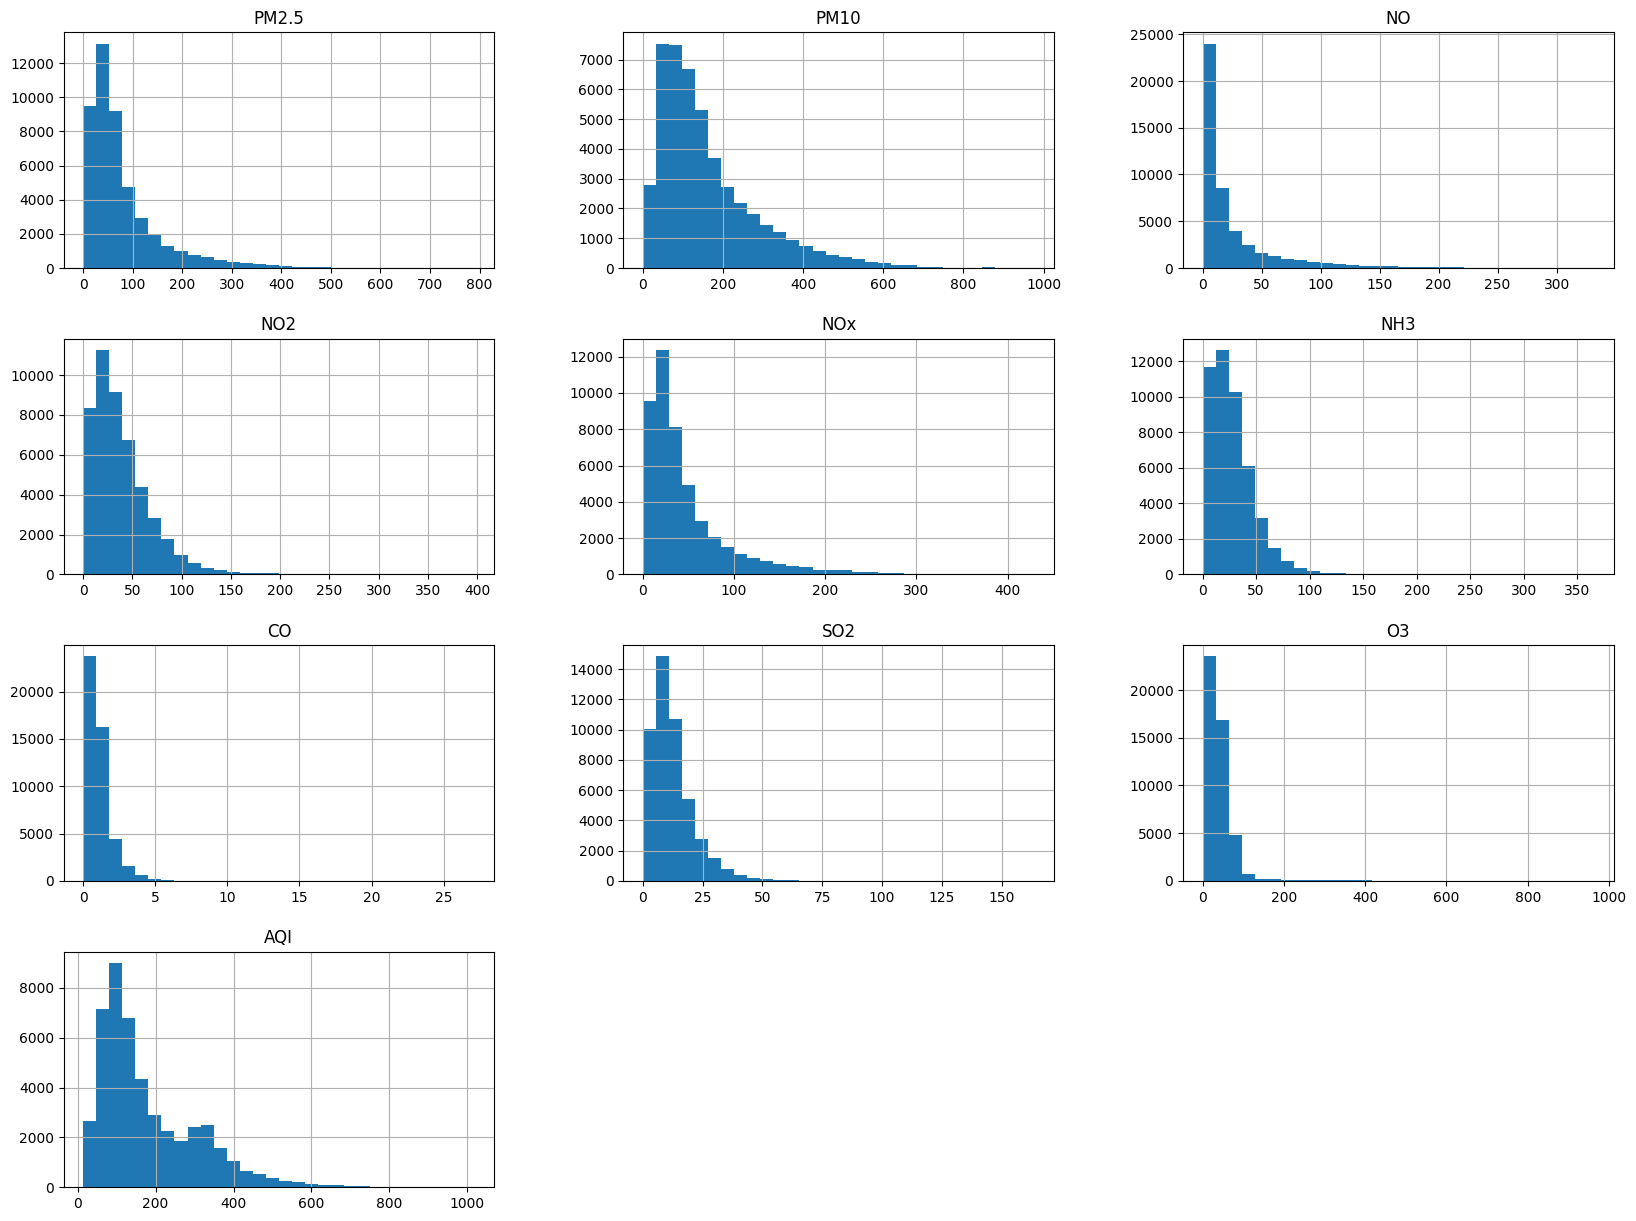

In [7]:
# EDA
# Histograms
df.hist(bins=30, figsize=(20, 15))
plt.show()

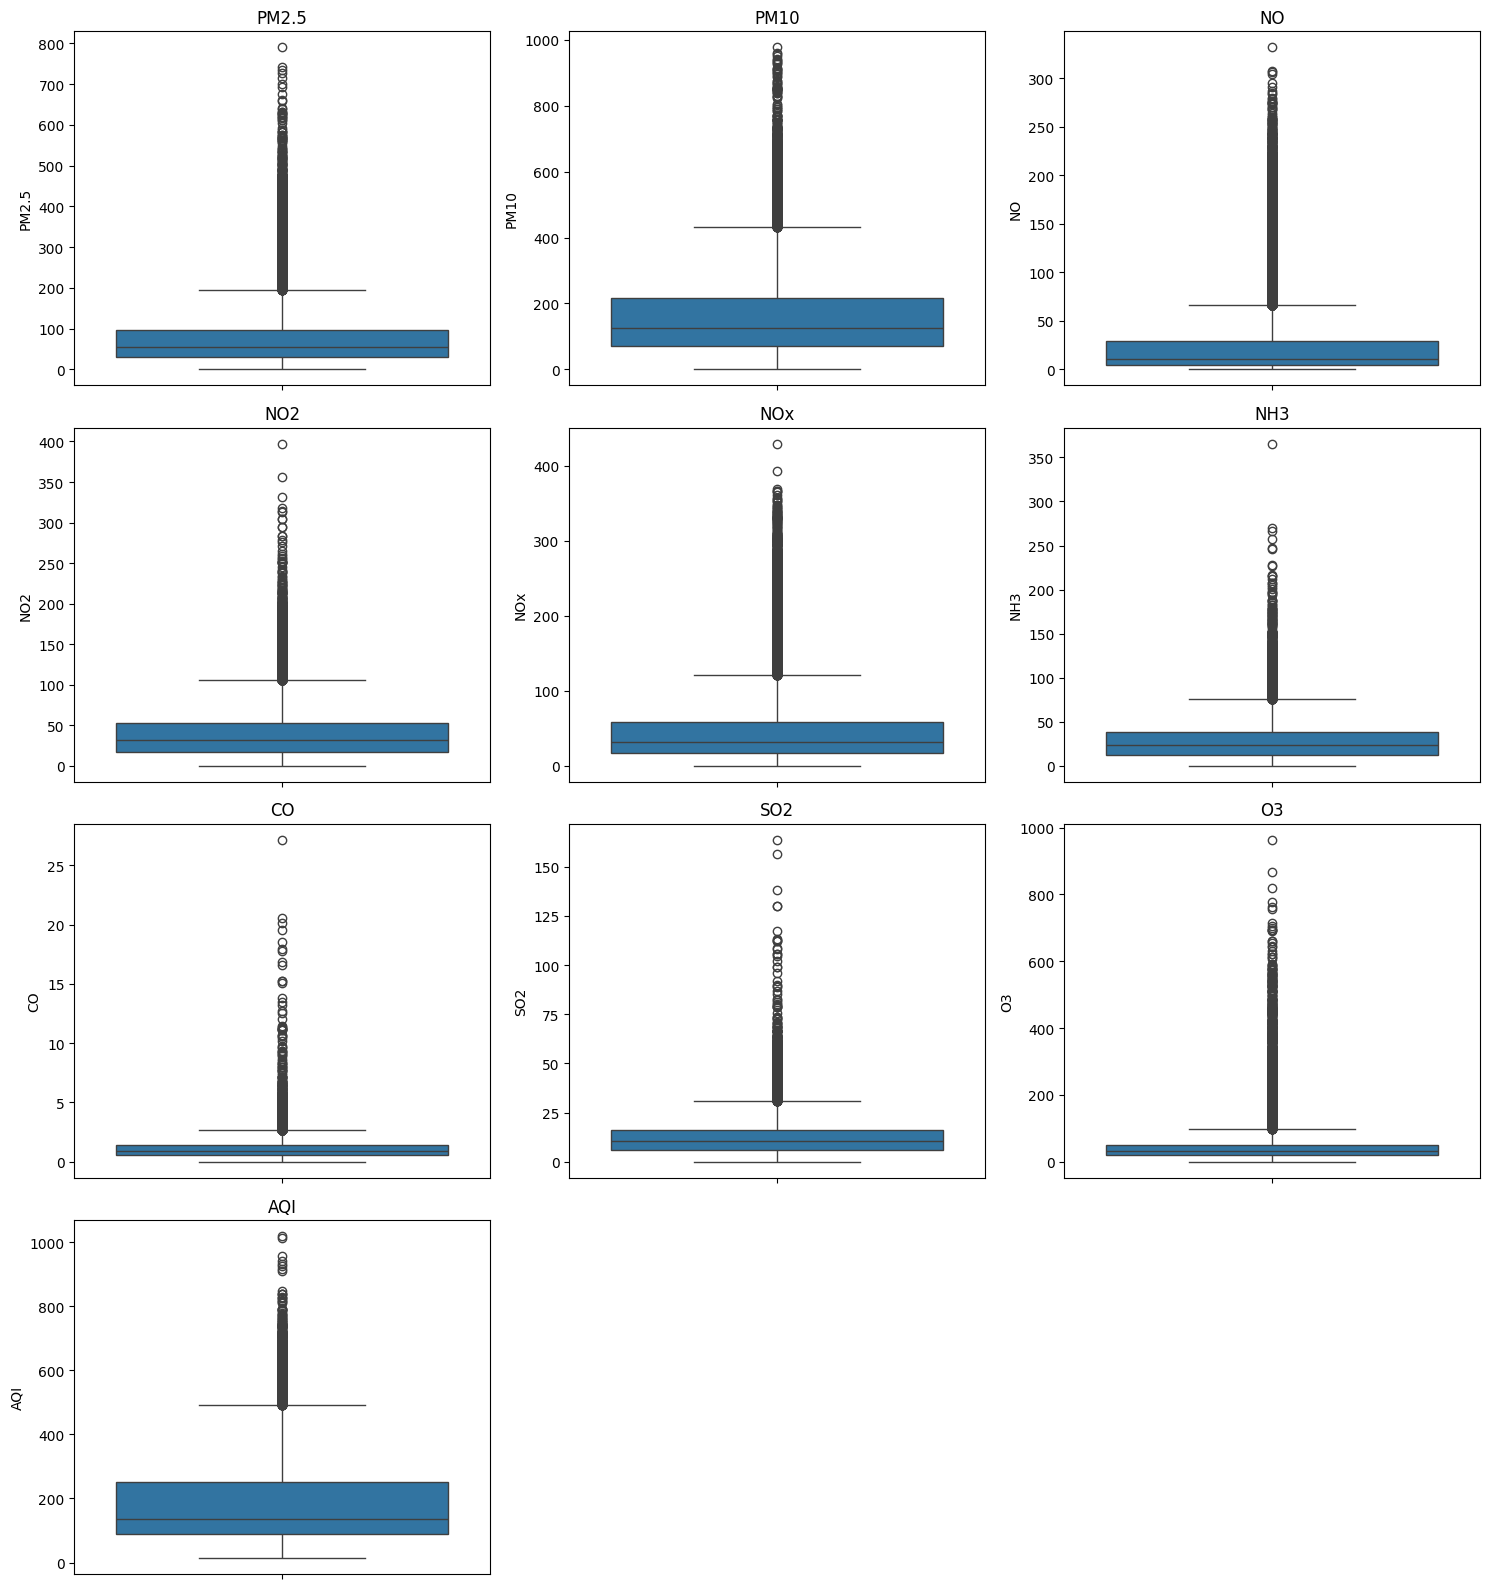

In [8]:
# Box plots
# Determine the number of rows and columns for subplots
n_cols = 3  # You can adjust the number of columns as needed
n_rows = (len(numerical_cols) + n_cols - 1) // n_cols # Calculate rows needed

plt.figure(figsize=(n_cols * 5, n_rows * 4)) # Adjust figure size based on subplots

for i, col in enumerate(numerical_cols):
    plt.subplot(n_rows, n_cols, i + 1) # Create a subplot for each column
    sns.boxplot(df[col])
    plt.title(f'{col}') # Title for the subplot
    plt.tight_layout()

plt.show()

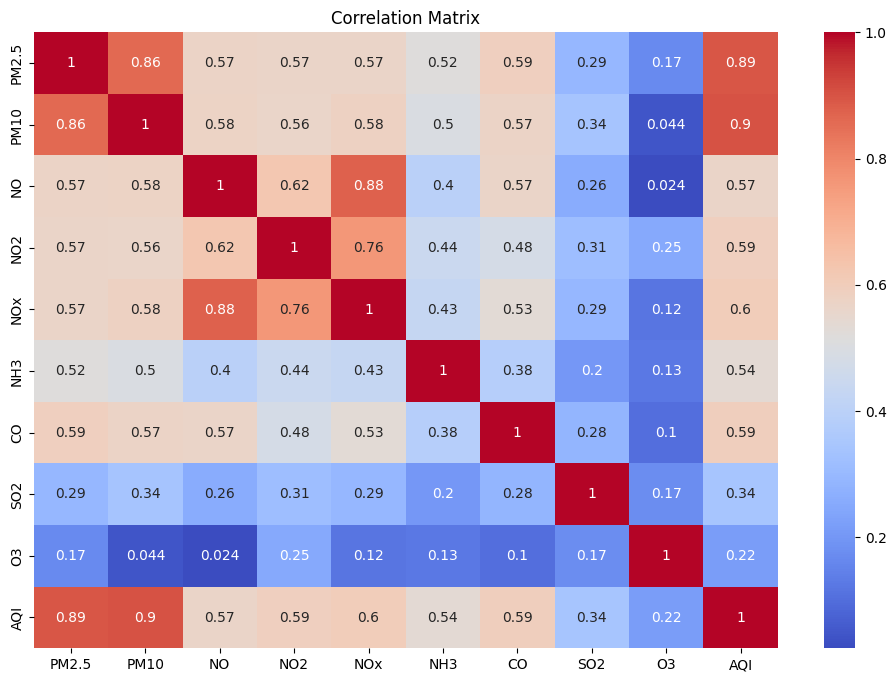

In [9]:
# Correlation matrix
# Select only numerical columns for correlation calculation
numerical_df = df.select_dtypes(include=np.number)
corr = numerical_df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

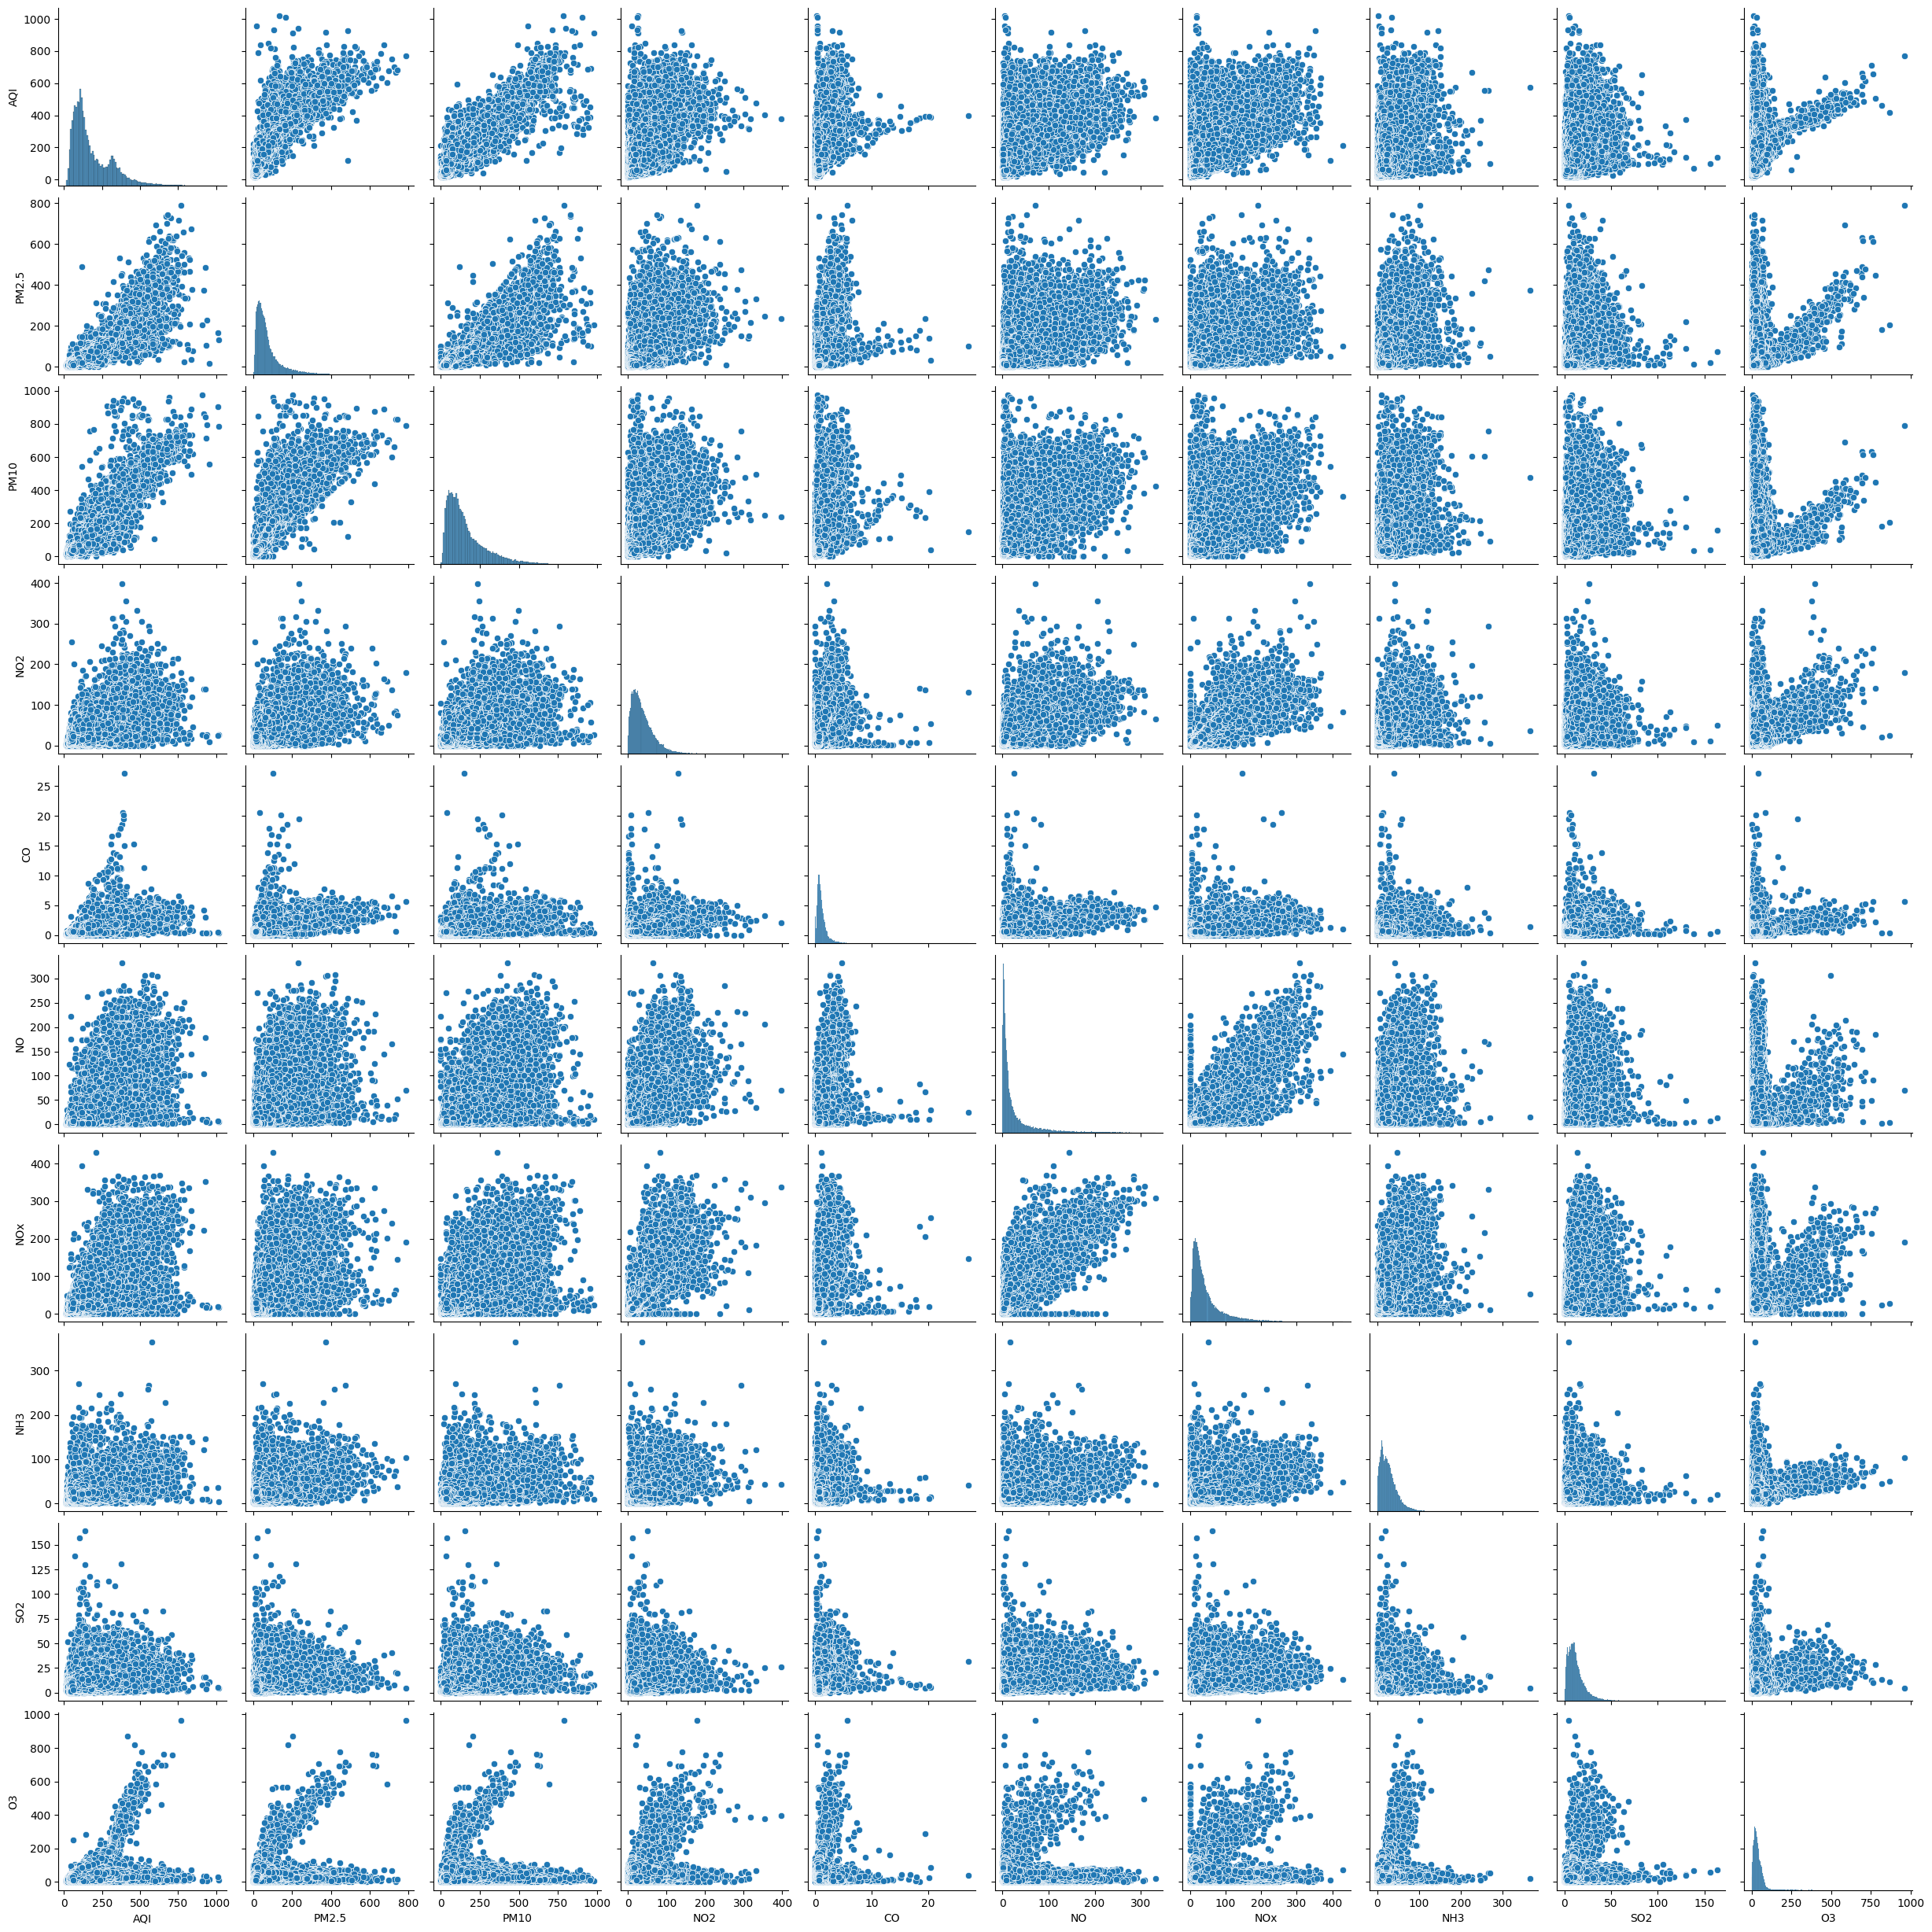

In [10]:
# Pair plots for selected features
selected_features = ['AQI', 'PM2.5', 'PM10', 'NO2', 'CO','NO','NOx','NH3','SO2','O3']
sns.pairplot(df[selected_features])
plt.show()

In [11]:
# Feature engineering
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'])
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Day'] = df['Date'].dt.day
    df['DayOfWeek'] = df['Date'].dt.dayofweek

In [12]:
# Outlier handling
features = [col for col in numerical_cols if col != 'AQI']
z_scores = np.abs(zscore(df[features]))
threshold = 3
df_removed = df[(z_scores < threshold).all(axis=1)]
means = df[features].mean()
stds = df[features].std()
lower = means - threshold * stds
upper = means + threshold * stds
df_capped = df.copy()
for col in features:
    df_capped[col] = np.clip(df_capped[col], lower[col], upper[col])


In [13]:
# Outlier handling: Z-score based capping and removal
features = [col for col in numerical_cols if col != 'AQI']
z_scores = np.abs(zscore(df[features]))

In [14]:
# Create dataset with outliers capped
means = df[features].mean()
stds = df[features].std()
lower = means - 3 * stds
upper = means + 3 * stds
df_capped = df.copy()
for col in features:
    df_capped[col] = np.clip(df_capped[col], lower[col], upper[col])

# Proceed with capped dataset (you can choose df_removed instead if preferred)
df = df_capped

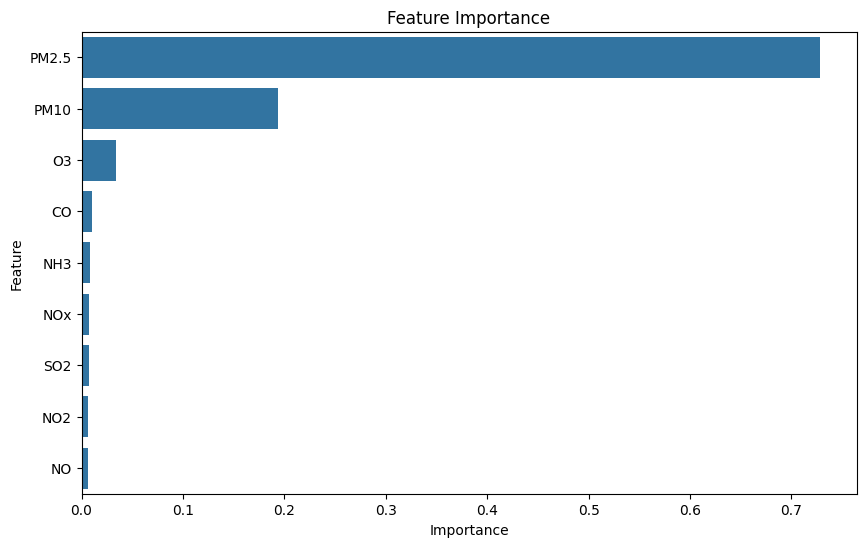

In [15]:
# Feature importance (using Random Forest on capped data)
rf = RandomForestRegressor(n_estimators=100)
rf.fit(df_capped[features], df_capped['AQI'])
importances = pd.DataFrame({'Feature': features, 'Importance': rf.feature_importances_})
importances = importances.sort_values('Importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importances)
plt.title('Feature Importance')
plt.show()

In [16]:
print(df.describe())

              PM2.5          PM10            NO           NO2           NOx  \
count  46981.000000  46981.000000  46981.000000  46981.000000  46981.000000   
mean      76.930111    160.970257     24.302544     38.118601     46.358441   
min        0.160000      0.180000      0.020000      0.010000      0.000000   
25%       30.570000     71.160000      4.230000     17.140000     16.610000   
50%       54.880000    124.650000     10.680000     31.600000     30.910000   
75%       96.590000    215.600000     28.880000     52.320000     58.290000   
max      306.523637    544.924314    136.721924    127.951923    193.608210   
std       68.562016    121.959997     32.355658     27.641570     44.296722   

                NH3            CO           SO2            O3           AQI  \
count  46981.000000  46981.000000  46981.000000  46981.000000  46981.000000   
mean      27.450491      1.100557     12.269765     39.061165    179.367936   
min        0.010000      0.000000      0.010000    

In [17]:
# Function to create sequences for LSTM and GRU
def create_sequences(df, seq_length, feature_cols, target_col):
    X, y = [], []
    for i in range(len(df) - seq_length):
        X.append(df[feature_cols].iloc[i:i+seq_length].values)
        y.append(df[target_col].iloc[i+seq_length])
    return np.array(X), np.array(y)


In [18]:
# Function to train and evaluate models
def train_evaluate(df, features, target='AQI', test_size=0.2, seq_length=7):
    # Sort by Date
    df = df.sort_values('Date')

    # Split data
    split_index = int((1 - test_size) * len(df))
    df_train = df.iloc[:split_index]
    df_test = df.iloc[split_index:]

    # Scale features
    scaler = StandardScaler()
    df_train_scaled = df_train.copy()
    df_test_scaled = df_test.copy()
    df_train_scaled[features] = scaler.fit_transform(df_train[features])
    df_test_scaled[features] = scaler.transform(df_test[features])

    X_train = df_train_scaled[features]
    y_train = df_train_scaled[target]
    X_test = df_test_scaled[features]
    y_test = df_test_scaled[target]

    # Standard regression models
    models = {
        'Linear Regression': LinearRegression(),
        'Decision Tree': DecisionTreeRegressor(),
        'SVR': SVR(kernel='linear', C=1),
        'Random Forest': RandomForestRegressor(n_estimators=100),
        'XGBoost': XGBRegressor(),
        'MLP Regressor': MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=500)
    }

    results = []
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        results.append({'Model': name, 'R2': r2, 'MAE': mae, 'RMSE': rmse})

        # Plot predicted vs actual
        plt.figure(figsize=(8, 6))
        plt.scatter(y_test, y_pred)
        plt.xlabel('Actual AQI')
        plt.ylabel('Predicted AQI')
        plt.title(f'{name}: Predicted vs Actual')
        plt.show()

    # Stacked Model
    val_size = 0.2
    split_val = int((1 - val_size) * len(df_train))
    df_train_sub = df_train_scaled.iloc[:split_val]
    df_val = df_train_scaled.iloc[split_val:]

    X_train_sub = df_train_sub[features]
    y_train_sub = df_train_sub[target]
    X_val = df_val[features]
    y_val = df_val[target]

    rf = RandomForestRegressor(n_estimators=100)
    rf.fit(X_train_sub, y_train_sub)
    y_pred_rf_val = rf.predict(X_val)
    y_pred_rf_test = rf.predict(X_test)

    xgb = XGBRegressor()
    xgb.fit(X_train_sub, y_train_sub)
    y_pred_xgb_val = xgb.predict(X_val)
    y_pred_xgb_test = xgb.predict(X_test)

    mlp = MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=500)
    mlp.fit(X_train_sub, y_train_sub)
    y_pred_mlp_val = mlp.predict(X_val)
    y_pred_mlp_test = mlp.predict(X_test)

    stacked_X_val = np.column_stack((y_pred_rf_val, y_pred_xgb_val, y_pred_mlp_val))
    meta_model = LinearRegression()
    meta_model.fit(stacked_X_val, y_val)

    stacked_X_test = np.column_stack((y_pred_rf_test, y_pred_xgb_test, y_pred_mlp_test))
    y_pred_stacked = meta_model.predict(stacked_X_test)

    r2_stacked = r2_score(y_test, y_pred_stacked)
    mae_stacked = mean_absolute_error(y_test, y_pred_stacked)
    rmse_stacked = np.sqrt(mean_squared_error(y_test, y_pred_stacked))
    results.append({'Model': 'Stacked Model', 'R2': r2_stacked, 'MAE': mae_stacked, 'RMSE': rmse_stacked})

    return pd.DataFrame(results)


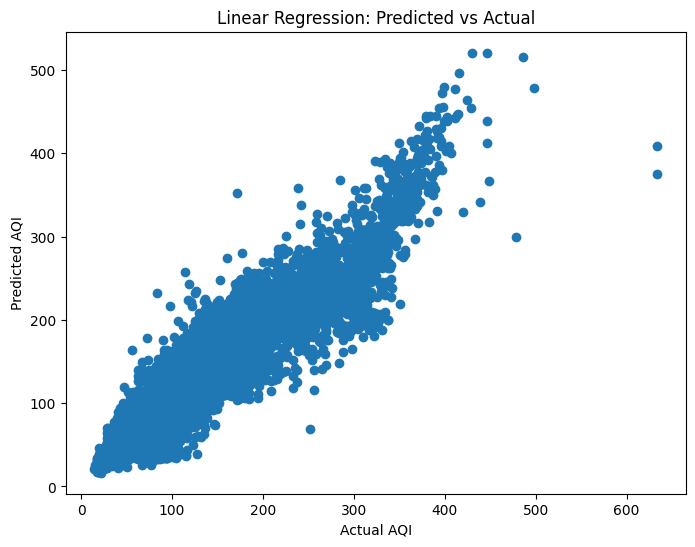

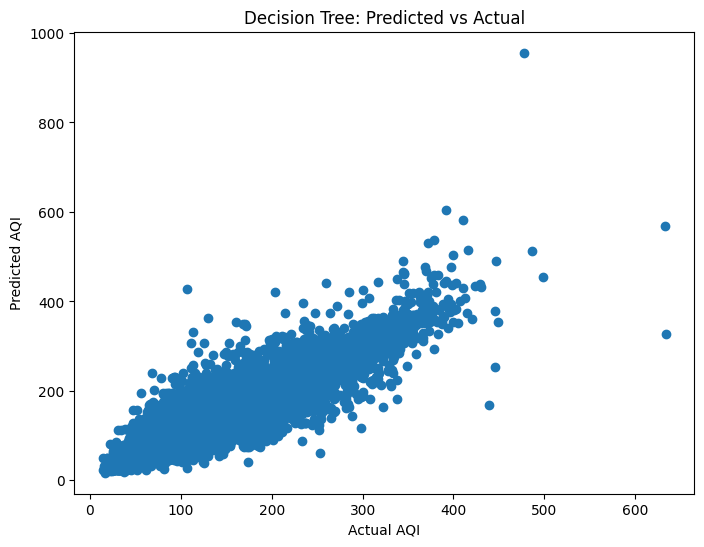

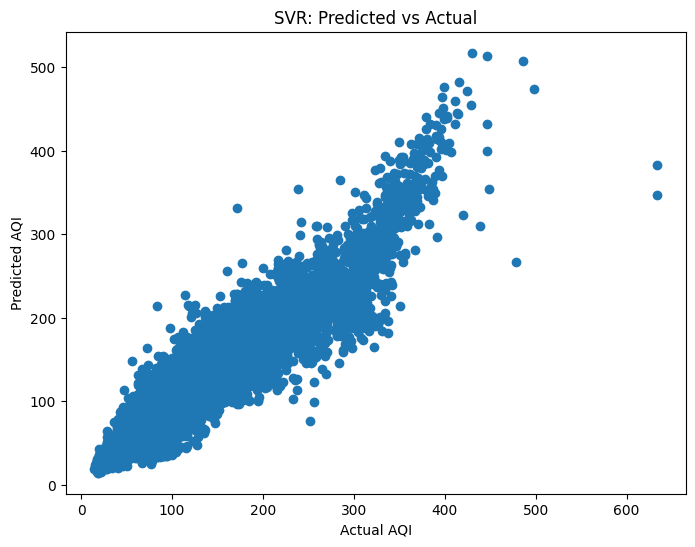

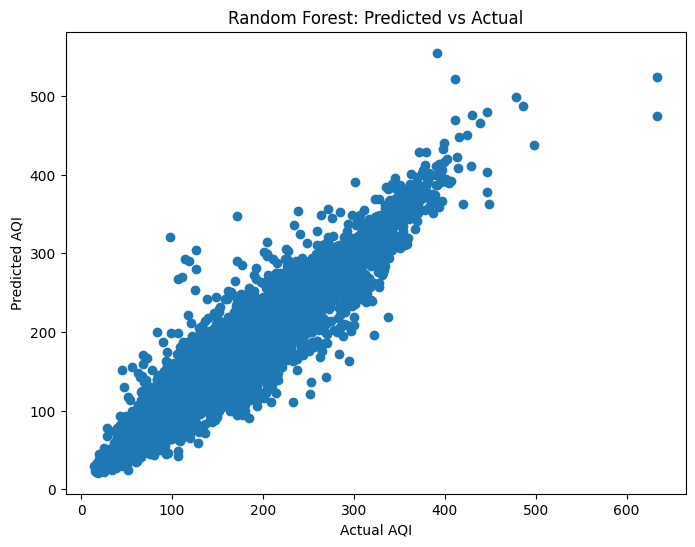

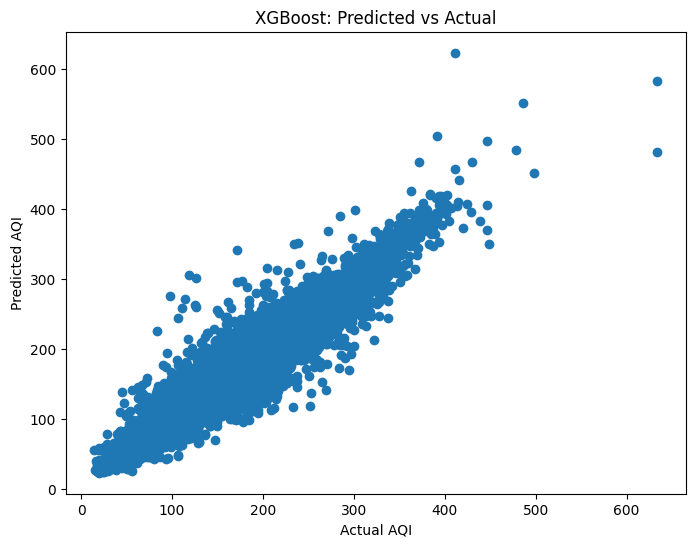

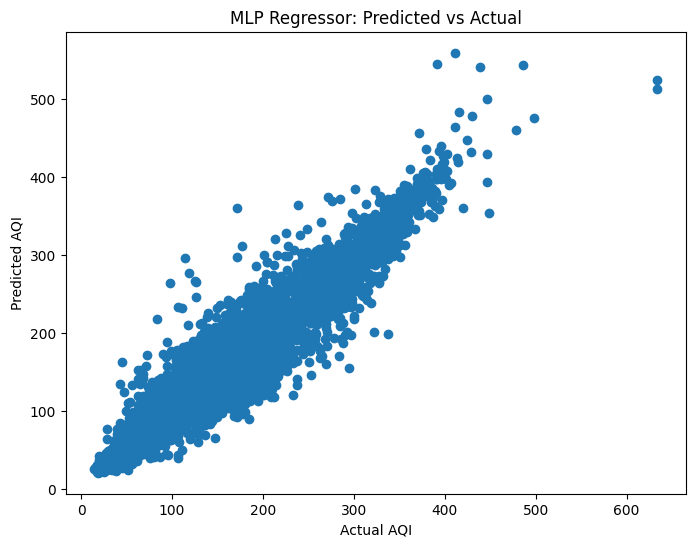

In [19]:
# Train and evaluate on both datasets
results_capped = train_evaluate(df_capped, features)

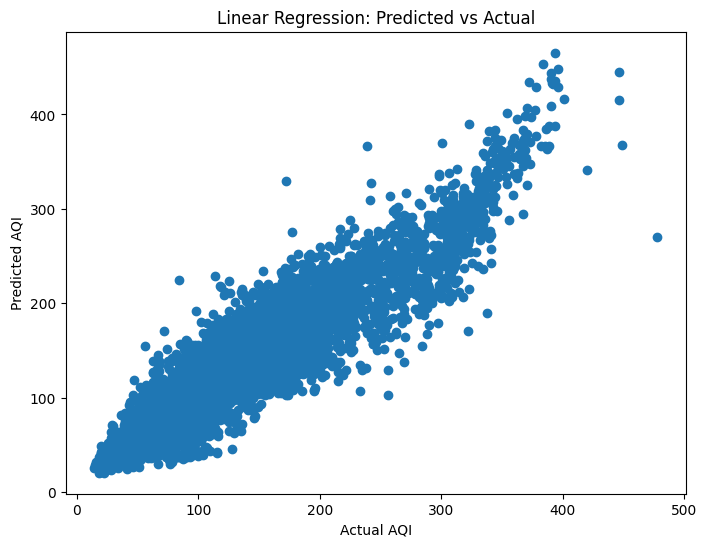

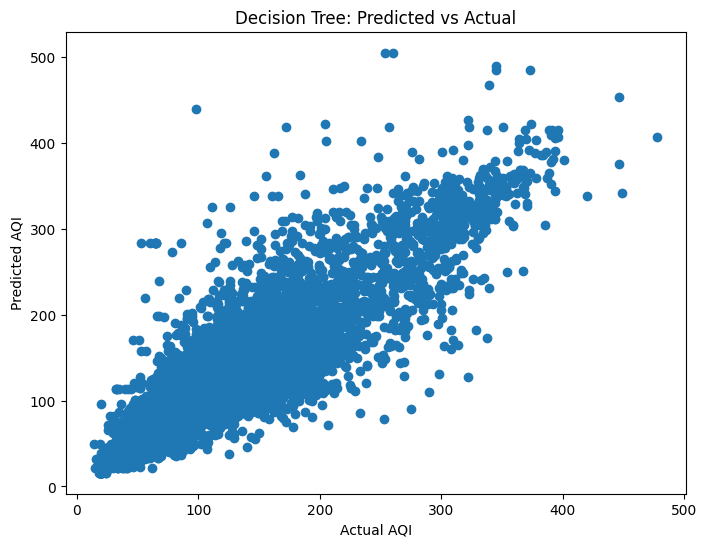

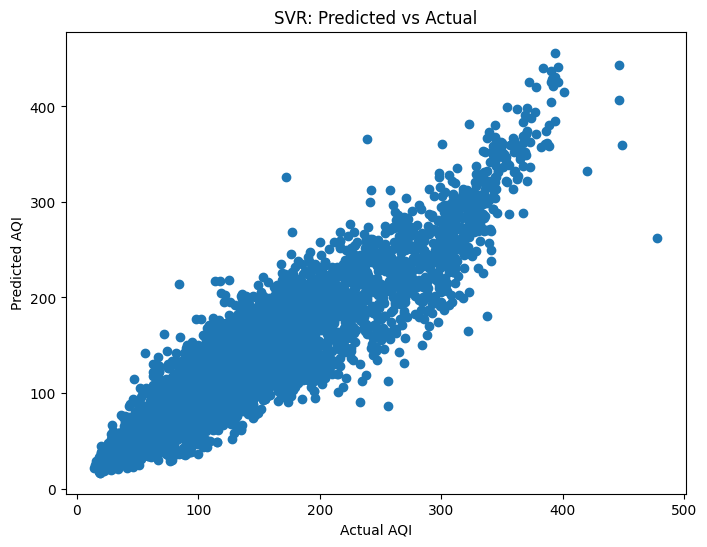

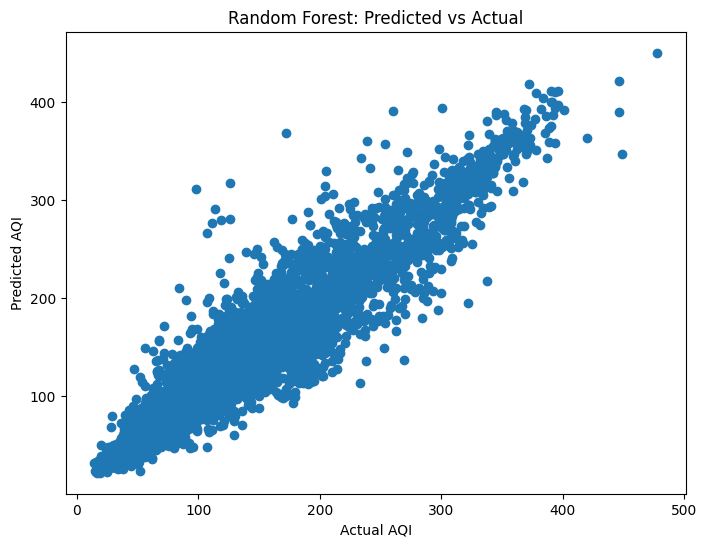

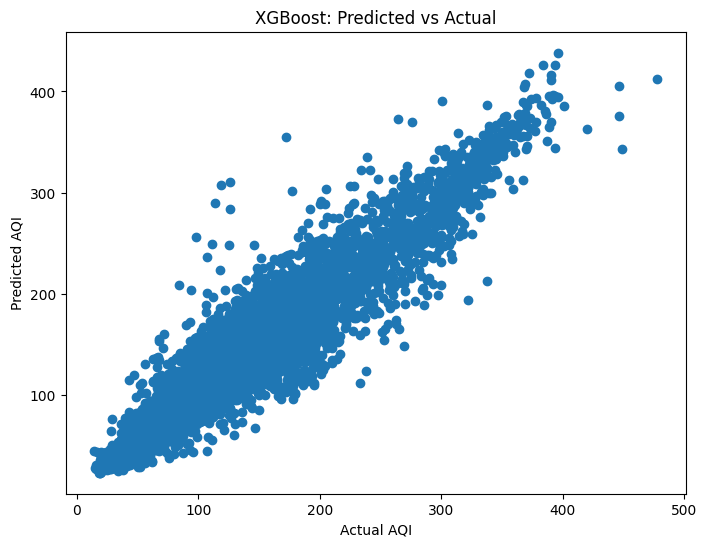

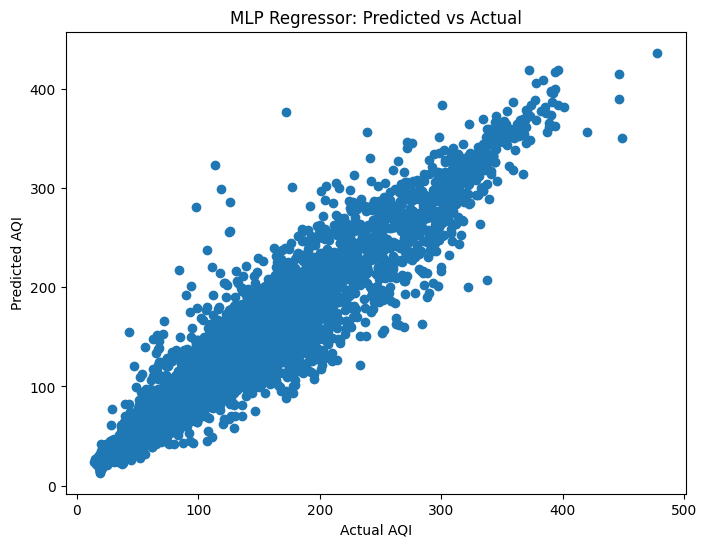

In [20]:
results_removed = train_evaluate(df_removed, features)

In [21]:
# Comparision of outlier handling
print("Results with Outliers Removed:")
print(results_removed)
# Save results to CSV
results_removed.to_csv('model_results_outliers_removed.csv', index=False)

Results with Outliers Removed:
               Model        R2        MAE       RMSE
0  Linear Regression  0.861115  20.299918  26.869616
1      Decision Tree  0.769054  22.689112  34.648850
2                SVR  0.864267  18.746655  26.562962
3      Random Forest  0.901403  15.514243  22.639435
4            XGBoost  0.904145  15.512812  22.322409
5      MLP Regressor  0.913241  14.222162  21.236930
6      Stacked Model  0.908437  15.264121  21.816913


In [22]:
print("\nResults with Outliers Capped:")
print(results_capped)

results_capped.to_csv('model_results_outliers_capped.csv', index=False)


Results with Outliers Capped:
               Model        R2        MAE       RMSE
0  Linear Regression  0.860296  22.179226  29.728058
1      Decision Tree  0.818586  22.488241  33.876479
2                SVR  0.869043  20.142100  28.782386
3      Random Forest  0.916541  15.771961  22.977248
4            XGBoost  0.915773  15.972408  23.082718
5      MLP Regressor  0.921970  15.153579  22.217437
6      Stacked Model  0.920685  15.382458  22.399535


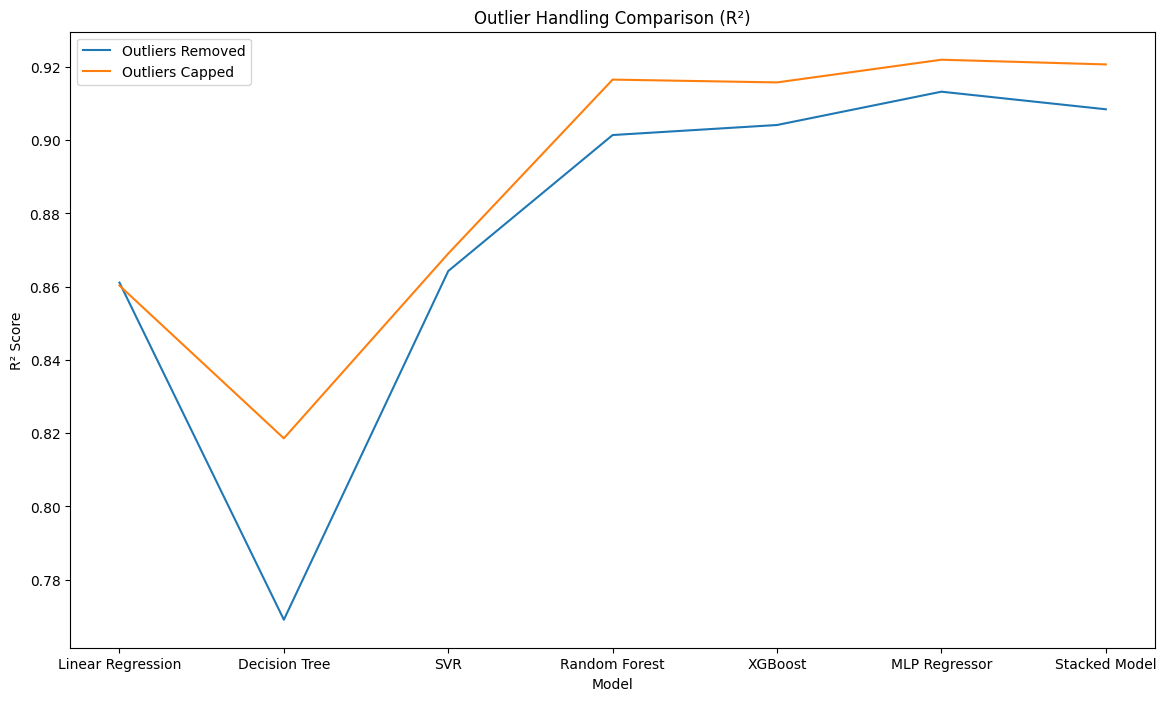

In [23]:
# Plot comparison
plt.figure(figsize=(14, 8))
plt.plot(results_removed['Model'], results_removed['R2'], label='Outliers Removed')
plt.plot(results_capped['Model'], results_capped['R2'], label='Outliers Capped')
plt.title('Outlier Handling Comparison (R²)')
plt.xlabel('Model')
plt.ylabel('R² Score')
plt.legend()
plt.show()
plt.savefig('outlier_comparison.png')
plt.close()


Evaluating best model for Outliers Removed dataset (based on R2):

Results sorted by R2:
               Model        R2        MAE       RMSE
5      MLP Regressor  0.913241  14.222162  21.236930
6      Stacked Model  0.908437  15.264121  21.816913
4            XGBoost  0.904145  15.512812  22.322409
3      Random Forest  0.901403  15.514243  22.639435
2                SVR  0.864267  18.746655  26.562962
0  Linear Regression  0.861115  20.299918  26.869616
1      Decision Tree  0.769054  22.689112  34.648850

Best Model based on R2:
Model    MLP Regressor
R2            0.913241
MAE          14.222162
RMSE          21.23693
Name: 5, dtype: object


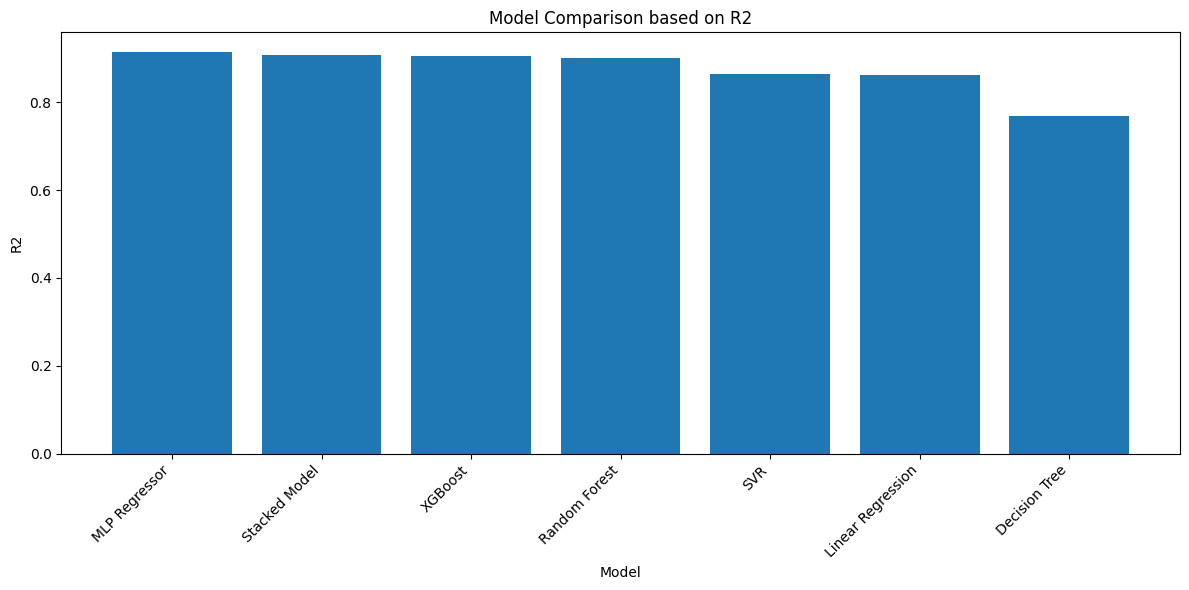


Evaluating best model for Outliers Capped dataset (based on R2):

Results sorted by R2:
               Model        R2        MAE       RMSE
5      MLP Regressor  0.921970  15.153579  22.217437
6      Stacked Model  0.920685  15.382458  22.399535
3      Random Forest  0.916541  15.771961  22.977248
4            XGBoost  0.915773  15.972408  23.082718
2                SVR  0.869043  20.142100  28.782386
0  Linear Regression  0.860296  22.179226  29.728058
1      Decision Tree  0.818586  22.488241  33.876479

Best Model based on R2:
Model    MLP Regressor
R2             0.92197
MAE          15.153579
RMSE         22.217437
Name: 5, dtype: object


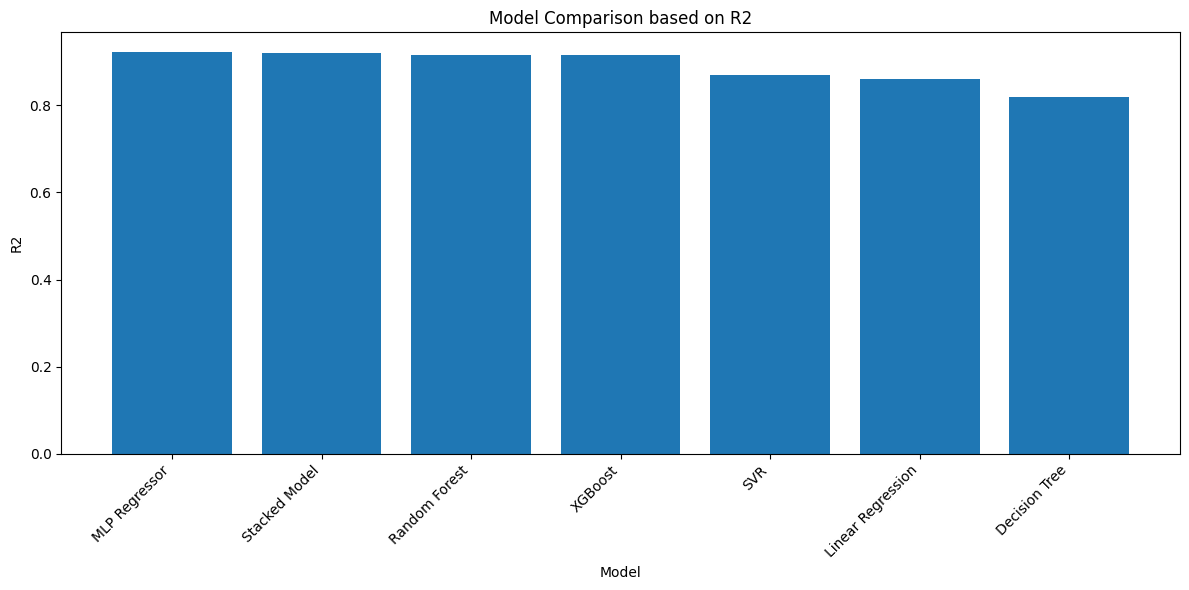

In [26]:
def print_best_model(results_df, metric='R2', ascending=False):
    """
    Prints the best performing model based on a given metric and plots the results.

    Args:
        results_df (pd.DataFrame): DataFrame containing model results (e.g., from train_evaluate).
        metric (str): The metric to use for determining the best model ('R2', 'MAE', 'RMSE').
        ascending (bool): Whether to sort in ascending order (True for MAE/RMSE, False for R2).
    """
    print(f"\nResults sorted by {metric}:")
    sorted_results = results_df.sort_values(metric, ascending=ascending)
    print(sorted_results)

    best_model_row = sorted_results.iloc[0]
    print(f"\nBest Model based on {metric}:")
    print(best_model_row)

    # Plotting the results using bar chart
    plt.figure(figsize=(12, 6))
    plt.bar(sorted_results['Model'], sorted_results[metric])
    plt.xlabel('Model')
    plt.ylabel(metric)
    plt.title(f'Model Comparison based on {metric}')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Print and plot best model for both outlier handling methods based on R2
print("\nEvaluating best model for Outliers Removed dataset (based on R2):")
print_best_model(results_removed, metric='R2', ascending=False)

print("\nEvaluating best model for Outliers Capped dataset (based on R2):")
print_best_model(results_capped, metric='R2', ascending=False)

# WE can also evaluate based on MAE or RMSE if desired
# print("\nEvaluating best model for Outliers Removed dataset (based on MAE):")
# print_best_model(results_removed, metric='MAE', ascending=True)

# print("\nEvaluating best model for Outliers Capped dataset (based on RMSE):")
# print_best_model(results_capped, metric='RMSE', ascending=True)


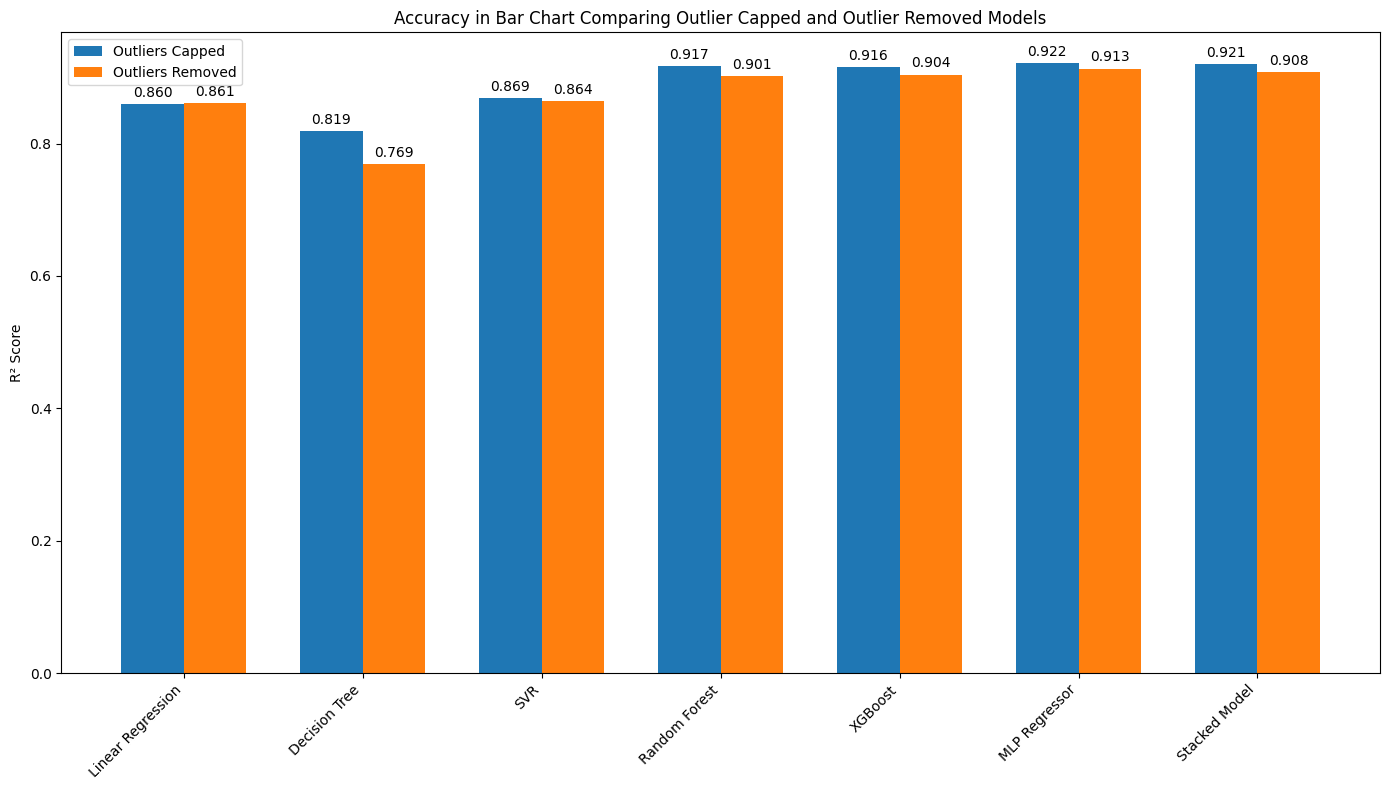

In [42]:
import matplotlib.pyplot as plt
import numpy as np
# Prepare data for the comparison bar chart
models = results_capped['Model'].tolist()
accuracy_capped = results_capped['R2'].tolist()
accuracy_removed = results_removed['R2'].tolist()

x = np.arange(len(models))
width = 0.35  # Width of the bars

fig, ax = plt.subplots(figsize=(14, 8))
rects1 = ax.bar(x - width/2, accuracy_capped, width, label='Outliers Capped')
rects2 = ax.bar(x + width/2, accuracy_removed, width, label='Outliers Removed')

# Add some text for labels, title and axes ticks
ax.set_ylabel('R² Score')
ax.set_title('Accuracy in Bar Chart Comparing Outlier Capped and Outlier Removed Models')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=45, ha="right")
ax.legend()

# Add numbers on top of the bars
def autolabel(rects):

    for rect in rects:
        height = rect.get_height()
        ax.annotate('%.3f' % height,
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.show()


In [25]:
# Assuming results_removed and results_capped are DataFrames with columns: 'Model', 'R2', 'MAE', 'RMSE'

# Find the best model for each outlier handling strategy based on R2
best_removed = results_removed.loc[results_removed['R2'].idxmax()]
best_capped = results_capped.loc[results_capped['R2'].idxmax()]

# Print the best model for each strategy
print("\nBest Model with Outliers Removed:")
print(f"Model: {best_removed['Model']}, R2: {best_removed['R2']}, MAE: {best_removed['MAE']}, RMSE: {best_removed['RMSE']}")

print("\nBest Model with Outliers Capped:")
print(f"Model: {best_capped['Model']}, R2: {best_capped['R2']}, MAE: {best_capped['MAE']}, RMSE: {best_capped['RMSE']}")

# Determine the overall best model based on R2
if best_removed['R2'] > best_capped['R2']:
    overall_best = best_removed
    handling = "outliers removed"
else:
    overall_best = best_capped
    handling = "outliers capped"

# Print the overall best model
print(f"\nOverall, the best model is {overall_best['Model']} with {handling}, achieving R2: {overall_best['R2']}, MAE: {overall_best['MAE']}, RMSE: {overall_best['RMSE']}")


Best Model with Outliers Removed:
Model: MLP Regressor, R2: 0.9130317702390841, MAE: 14.691832402059116, RMSE: 21.26248336557077

Best Model with Outliers Capped:
Model: MLP Regressor, R2: 0.9222354774661881, MAE: 15.293082377227059, RMSE: 22.17956756100499

Overall, the best model is MLP Regressor with outliers capped, achieving R2: 0.9222354774661881, MAE: 15.293082377227059, RMSE: 22.17956756100499
